In [ ]:
!pip install torch transformers datasets

In [ ]:
from transformers import pipeline
from datasets import load_dataset
import pandas as pd
import ast
from tqdm import tqdm
import json

tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare Data

In [ ]:

ds = load_dataset("JanosAudran/financial-reports-sec", "small_full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

financial-reports-sec.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

The repository for JanosAudran/financial-reports-sec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/JanosAudran/financial-reports-sec.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


shard_0.jsonl:   0%|          | 0.00/2.88M [00:00<?, ?B/s]

shard_1.jsonl:   0%|          | 0.00/214k [00:00<?, ?B/s]

shard_2.jsonl:   0%|          | 0.00/674k [00:00<?, ?B/s]

data/small/test/shard_3.jsonl: 0.00B [00:00, ?B/s]

shard_0.jsonl:   0%|          | 0.00/3.65M [00:00<?, ?B/s]

shard_1.jsonl:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

shard_2.jsonl:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

shard_3.jsonl:   0%|          | 0.00/2.59M [00:00<?, ?B/s]

shard_4.jsonl:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

shard_5.jsonl:   0%|          | 0.00/3.20M [00:00<?, ?B/s]

shard_6.jsonl:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

shard_7.jsonl:   0%|          | 0.00/4.35M [00:00<?, ?B/s]

shard_8.jsonl:   0%|          | 0.00/4.40M [00:00<?, ?B/s]

shard_9.jsonl:   0%|          | 0.00/287k [00:00<?, ?B/s]

shard_0.jsonl:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

shard_1.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

shard_2.jsonl:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
df = ds["train"].to_pandas()
COLS = ["sentenceID", "sentence", "docID", "filingDate", "section", "name", "labels", "tickers", "reportDate", "returns"]
df = df[COLS]


# convert the dict val inside the labels col to 3 separate cols for 1d, 5d and 30d window.
def parse_labels(label):
    if isinstance(label, str):  # Check if the entry is a string
        try:
            return json.loads(label.replace("'", '"'))  # Convert single quotes to double quotes for JSON
        except json.JSONDecodeError as e:
            print(f"Error parsing label: {label} -> {e}")
            return {}  # Return an empty dict if parsing fails
    return label


labels_df = df['labels'].progress_apply(parse_labels).progress_apply(pd.Series)
labels_df.columns = [f"label_{col}" for col in labels_df.columns]
df = pd.concat([df, labels_df], axis=1).drop(columns=['labels'])

100%|██████████| 200000/200000 [00:45<00:00, 4391.14it/s]


In [ ]:
df.head()

,sentenceID,sentence,docID,filingDate,section,name,tickers,reportDate,returns,label_1d,label_5d,label_30d
0,0000001750_10-K_2020_section_1_0,ITEM 1.BUSINESS General AAR CORP. and its subs...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0
1,0000001750_10-K_2020_section_1_1,"AAR was founded in 1951, organized in 1955 and...",0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0
2,0000001750_10-K_2020_section_1_2,We are a diversified provider of products and ...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0
3,0000001750_10-K_2020_section_1_3,Fiscal 2020 began with strategic initiatives f...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0
4,0000001750_10-K_2020_section_1_4,Our momentum from a successful fiscal 2019 car...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0


## Extract Sentiments

In [ ]:
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert", device=0, truncation=True)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# testing on few rows
sentiment_pipeline(df.iloc[0:5]['sentence'].tolist(),)

[{'label': 'neutral', 'score': 0.9483352899551392},
 {'label': 'neutral', 'score': 0.9519177079200745},
 {'label': 'neutral', 'score': 0.8594400882720947},
 {'label': 'positive', 'score': 0.6688447594642639},
 {'label': 'positive', 'score': 0.953032374382019}]

In [ ]:
texts = df['sentence'].tolist()

sentiment_labels = []
batch_size = 64

for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
    batch_texts = texts[i:i+batch_size]
    batch_results = sentiment_pipeline(batch_texts, truncation=True, batch_size=batch_size)
    sentiment_labels.extend([res['label'] for res in batch_results])

Processing Batches:   3%|▎         | 80/3125 [00:38<24:34,  2.06it/s]


KeyboardInterrupt: 

In [ ]:
df['sentiment'] = sentiment_labels

NameError: name 'sentiment_labels' is not defined

In [ ]:
df.to_csv("10k_sentences_small_sentiments.csv")

In [ ]:
df['sentiment'].value_counts()

sentiment
neutral     150589
negative     29999
positive     19412
Name: count, dtype: int64

In [ ]:
df.head()

,sentenceID,sentence,docID,filingDate,section,name,tickers,reportDate,returns,label_1d,label_5d,label_30d,sentiment
0,0000001750_10-K_2020_section_1_0,ITEM 1.BUSINESS General AAR CORP. and its subs...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0,neutral
1,0000001750_10-K_2020_section_1_1,"AAR was founded in 1951, organized in 1955 and...",0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0,neutral
2,0000001750_10-K_2020_section_1_2,We are a diversified provider of products and ...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0,neutral
3,0000001750_10-K_2020_section_1_3,Fiscal 2020 began with strategic initiatives f...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0,positive
4,0000001750_10-K_2020_section_1_4,Our momentum from a successful fiscal 2019 car...,0000001750_10-K_2020,2020-07-21,0,AAR CORP,[AIR],2020-05-31,{'1d': {'closePriceEndDate': 19.01000022888183...,0,1,0,positive


# Correlation Analysis

In [ ]:
# Import required libraries
import pandas as pd
from google.colab import drive

# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Define the path to your CSV file
# Adjust the path below to match your Google Drive structure
data_path = '/content/drive/MyDrive/Colab Notebooks/data vis/10k_sentences_large100_sentiments.csv.gz'

# Load the dataset
try:
    df = pd.read_csv(data_path, compression='gzip', low_memory=False)
    print(f"Dataset loaded successfully with {len(df)} rows and {len(df.columns)} columns")

    # Convert label columns back to dictionaries if they were stored as strings
    label_cols = [col for col in df.columns if col.startswith('label_')]
    for col in label_cols:
        try:
            df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        except:
            print(f"Warning: Could not convert {col} to dictionary format")

    # Display the first few rows and data info
    print("\nFirst few rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())

except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    print("Please check if the file path is correct and the file exists in your Google Drive")
except Exception as e:
    print(f"Error loading dataset: {str(e)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully with 1130395 rows and 14 columns

First few rows:
   Unnamed: 0                        sentenceID  \
0           0  0000001750_10-K_2020_section_1_0   
1           1  0000001750_10-K_2020_section_1_1   
2           2  0000001750_10-K_2020_section_1_2   
3           3  0000001750_10-K_2020_section_1_3   
4           4  0000001750_10-K_2020_section_1_4   

                                            sentence                 docID  \
0  ITEM 1.BUSINESS General AAR CORP. and its subs...  0000001750_10-K_2020   
1  AAR was founded in 1951, organized in 1955 and...  0000001750_10-K_2020   
2  We are a diversified provider of products and ...  0000001750_10-K_2020   
3  Fiscal 2020 began with strategic initiatives f...  0000001750_10-K_2020   
4  Our momentum from a successful fiscal 2019 car...  0000001750_10-K_2020   

   filingDate  se

In [ ]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Convert sentiment labels to numeric values
def encode_sentiments(df):
    """
    Convert sentiment labels to numeric values:
    positive: 1, neutral: 0, negative: -1
    """
    sentiment_map = {
        'positive': 1,
        'neutral': 0,
        'negative': -1
    }
    return df['sentiment'].map(sentiment_map)


In [ ]:
def aggregate_document_sentiments(df):
    """
    Aggregate sentiments at document level with improved metrics
    """
    # Convert sentiments to numeric
    sentiment_map = {
        'positive': 1,
        'negative': -1
    }

    # Filter out neutral sentiments
    df_no_neutral = df[df['sentiment'].isin(['positive', 'negative'])]
    df_no_neutral['sentiment_score'] = df_no_neutral['sentiment'].map(sentiment_map)

    # Group by document ID with simplified metrics
    doc_sentiments = df_no_neutral.groupby('docID').agg({
        'sentiment_score': [
            ('sentiment_strength', 'mean'),  # Single measure of overall sentiment
            ('sentiment_count', 'count'),    # Number of sentiment expressions
            ('sentiment_std', 'std')         # Measure of sentiment consistency
        ]
    })

    # Flatten column names
    doc_sentiments.columns = ['_'.join(col).strip() for col in doc_sentiments.columns]

    return doc_sentiments

In [ ]:
def prepare_price_data(df):
    """
    Prepare price data using actual returns instead of binary labels
    """
    print("\nExtracting return values from nested dictionaries...")

    price_data = df.groupby('docID').first()
    returns_data = pd.DataFrame(index=price_data.index)

    # Extract actual return values instead of binary labels
    for period in ['1d', '5d', '30d']:
        col = f'label_{period}'
        if col in price_data.columns:
            # Assuming the nested dictionary contains 'return' key with actual return value
            # Modify this based on your actual data structure
            try:
                returns_data[f'return_{period}'] = price_data[col].apply(
                    lambda x: float(x['return']) if isinstance(x, dict) and 'return' in x else x
                )
            except:
                print(f"Warning: Could not extract actual returns for {period}, falling back to binary labels")
                returns_data[f'return_{period}'] = price_data[col].astype(float)

    return returns_data

In [ ]:
def calculate_correlations(sentiment_data, returns_data):
    """
    Calculate correlations with updated column names
    """
    # Combine sentiment and returns data
    combined_data = pd.concat([sentiment_data, returns_data], axis=1)

    # Update column names to match new aggregation
    sentiment_cols = ['sentiment_score_sentiment_strength',
                     'sentiment_score_sentiment_count',
                     'sentiment_score_sentiment_std']
    return_cols = ['return_1d', 'return_5d', 'return_30d']

    correlations = {}
    for method in ['pearson', 'spearman']:
        try:
            corr_matrix = combined_data[sentiment_cols + return_cols].corr(method=method)
            correlations[method] = corr_matrix
            print(f"\n{method.capitalize()} correlations:")
            print(corr_matrix.loc[sentiment_cols, return_cols])
        except Exception as e:
            print(f"Error calculating {method} correlation: {str(e)}")

    return correlations, combined_data

In [ ]:
def validate_data(df):
    """
    Validate data before analysis, showing distribution of non-neutral sentiments
    """
    print("\nValidating data...")
    print(f"Total rows: {len(df)}")
    print(f"Unique documents: {df['docID'].nunique()}")

    # Filter out neutral sentiments for distribution analysis
    df_no_neutral = df[df['sentiment'].isin(['positive', 'negative'])]
    print("\nNon-neutral sentiment distribution:")
    print(df_no_neutral['sentiment'].value_counts(normalize=True))

    print("\nLabel distributions:")
    for col in ['label_1d', 'label_5d', 'label_30d']:
        if col in df.columns:
            print(f"\n{col}:")
            print(df[col].value_counts(normalize=True))
# Visualization functions
def plot_correlation_heatmap(correlation_matrix, title):
    """
    Create a correlation heatmap
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_scatter_relationships(combined_data, sentiment_col, return_col):
    """
    Create scatter plot with regression line
    """
    plt.figure(figsize=(10, 6))
    sns.regplot(data=combined_data, x=sentiment_col, y=return_col, scatter_kws={'alpha':0.5})
    plt.title(f'{sentiment_col} vs {return_col}')
    plt.tight_layout()
    plt.show()


In [ ]:
def test_significance(combined_data, sentiment_cols, return_cols):
    """
    Test significance with updated column names
    """
    significance_results = []

    # Update sentiment columns to match new names
    sentiment_cols = ['sentiment_score_sentiment_strength',
                     'sentiment_score_sentiment_count',
                     'sentiment_score_sentiment_std']

    for s_col in sentiment_cols:
        for r_col in return_cols:
            valid_data = combined_data[[s_col, r_col]].dropna()

            if len(valid_data) < 2:
                continue

            corr, p_value = stats.pearsonr(valid_data[s_col], valid_data[r_col])
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                valid_data[s_col], valid_data[r_col]
            )

            significance_results.append({
                'sentiment_metric': s_col,
                'return_period': r_col,
                'correlation': corr,
                'p_value': p_value,
                'slope': slope,
                'r_squared': r_value**2,
                'std_error': std_err,
                'significant': p_value < 0.05
            })

    return pd.DataFrame(significance_results)

In [ ]:
def format_correlation_results(correlations, significance_results):
    """
    Format correlation results into a readable text summary
    """
    summary = []

    # Overall summary statistics
    summary.append("=== DOCUMENT-LEVEL SENTIMENT SUMMARY ===")
    summary.append(f"Number of documents analyzed: {len(significance_results['sentiment_metric'].unique())}")

    # Add data quality information
    summary.append("\n=== DATA QUALITY SUMMARY ===")
    for col in significance_results['return_period'].unique():
        valid_count = significance_results[
            (significance_results['return_period'] == col) &
            (~significance_results['correlation'].isna())
        ].shape[0]
        summary.append(f"Valid correlations for {col}: {valid_count}")

    # Correlation results for each time window
    for window in ['1d', '5d', '30d']:
        summary.append(f"\n=== {window.upper()} RETURN CORRELATIONS ===")

        # Filter significance results for this window
        window_results = significance_results[
            significance_results['return_period'] == f'return_{window}'
        ]

        for _, result in window_results.iterrows():
            metric_name = result['sentiment_metric'].replace('sentiment_score_', '').replace('_', ' ').title()
            summary.append(f"{metric_name}:")

            if pd.isna(result['correlation']):
                summary.append("  No valid correlation (insufficient data)")
                continue

            # Format correlation and p-value with appropriate precision
            corr = f"{result['correlation']:.4f}"
            p_val = f"{result['p_value']:.4f}"

            # Create significance indicator
            sig_indicator = "**" if result['significant'] else ""

            summary.append(f"  Correlation: {corr} {sig_indicator}")
            summary.append(f"  P-value: {p_val}")

            # Add interpretation
            if result['significant']:
                strength = abs(result['correlation'])
                if strength > 0.5:
                    strength_desc = "strong"
                elif strength > 0.3:
                    strength_desc = "moderate"
                else:
                    strength_desc = "weak"

                direction = "positive" if result['correlation'] > 0 else "negative"
                summary.append(f"  Interpretation: {strength_desc} {direction} correlation (statistically significant)")
            else:
                summary.append("  Interpretation: No statistically significant correlation")

    return "\n".join(summary)

In [ ]:
def run_sentiment_correlation_analysis(df):
    print("\nStarting sentiment / price correlation analysis...")

    validate_data(df)

    # Aggregate sentiments
    doc_sentiments = aggregate_document_sentiments(df)

    # Prepare returns data
    returns_data = prepare_price_data(df)

    # Calculate correlations
    correlations, combined_data = calculate_correlations(doc_sentiments, returns_data)

    print("\nFinal dataset statistics:")
    print(combined_data.describe())

    # 4. Perform significance testing
    sentiment_cols = ['sentiment_score_mean_sentiment', 'sentiment_score_pos_ratio',
                     'sentiment_score_neg_ratio', 'sentiment_score_sentiment_std']
    return_cols = ['return_1d', 'return_5d', 'return_30d']

    significance_results = test_significance(combined_data, sentiment_cols, return_cols)

    # 5. Format and return text results
    text_results = format_correlation_results(correlations, significance_results)

    # 6. Return both text results and data for potential further analysis
    return {
        'text_results': text_results,
        'document_sentiments': doc_sentiments,
        'correlations': correlations,
        'significance_results': significance_results,
        'combined_data': combined_data
    }


In [ ]:
pip install seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_visualizations(combined_data, correlations, significance_results):
    """
    Create visualizations with updated column names
    """
    plt.style.use('default')

    def plot_correlation_heatmaps(correlations):
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Update column names
        sentiment_cols = ['sentiment_score_sentiment_strength',
                         'sentiment_score_sentiment_count',
                         'sentiment_score_sentiment_std']
        return_cols = [col for col in combined_data.columns if 'return' in col]

        for idx, method in enumerate(['pearson', 'spearman']):
            if method in correlations:
                corr_matrix = correlations[method].loc[sentiment_cols, return_cols]

                sns.heatmap(corr_matrix,
                           annot=True,
                           cmap='RdBu',
                           center=0,
                           vmin=-1,
                           vmax=1,
                           ax=axes[idx],
                           fmt='.3f')

                axes[idx].set_title(f'{method.capitalize()} Correlation Matrix')
                axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()


    def plot_scatter_matrix():
        sentiment_cols = ['sentiment_score_sentiment_strength',
                         'sentiment_score_sentiment_count',
                         'sentiment_score_sentiment_std']
        return_cols = [col for col in combined_data.columns if 'return' in col]

        n_sentiment = len(sentiment_cols)
        n_returns = len(return_cols)

        fig, axes = plt.subplots(n_sentiment, n_returns, figsize=(15, 15))

        for i, s_col in enumerate(sentiment_cols):
            for j, r_col in enumerate(return_cols):
                ax = axes[i, j]
                sns.regplot(data=combined_data,
                          x=s_col,
                          y=r_col,
                          scatter_kws={'alpha':0.5},
                          line_kws={'color': 'red'},
                          ax=ax)

                corr = combined_data[s_col].corr(combined_data[r_col])
                ax.set_title(f'Correlation: {corr:.3f}')
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()

    # Execute visualizations
    print("Generating correlation heatmaps...")
    plot_correlation_heatmaps(correlations)
    print("\nGenerating scatter matrix...")
    plot_scatter_matrix()

    def plot_sentiment_distributions():
        """
        Plot distributions of sentiment metrics
        """
        sentiment_cols = [col for col in combined_data.columns if 'sentiment' in col]

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()

        for idx, col in enumerate(sentiment_cols):
            # Create distribution plot
            sns.histplot(data=combined_data, x=col, ax=axes[idx], kde=True)
            axes[idx].set_title(f'Distribution of {col}')

        plt.tight_layout()
        plt.show()

    def plot_return_distributions():
        """
        Plot distributions of returns
        """
        return_cols = [col for col in combined_data.columns if 'return' in col]

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, col in enumerate(return_cols):
            # Create distribution plot
            sns.histplot(data=combined_data, x=col, ax=axes[idx], kde=True)
            axes[idx].set_title(f'Distribution of {col}')

        plt.tight_layout()
        plt.show()

    def plot_significance_results():
        """
        Plot correlation coefficients with significance indicators
        """
        # Prepare data for plotting
        plot_data = significance_results.copy()
        plot_data['significant'] = plot_data['p_value'] < 0.05

        plt.figure(figsize=(12, 6))

        # Create grouped bar plot
        sns.barplot(data=plot_data,
                   x='sentiment_metric',
                   y='correlation',
                   hue='return_period',
                   palette='Set2')

        # Add significance markers
        for idx, row in plot_data.iterrows():
            if row['significant']:
                plt.plot(idx, row['correlation'], 'k*', markersize=10)

        plt.xticks(rotation=45, ha='right')
        plt.title('Correlation Coefficients with Significance Markers (*)')
        plt.tight_layout()
        plt.show()

    def plot_time_series():
        """
        Plot average sentiment over time with returns
        """
        # Assuming we have a date column, if not, we'll need to add it
        if 'filingDate' in combined_data.columns:
            plt.figure(figsize=(15, 8))

            # Plot sentiment
            plt.subplot(2, 1, 1)
            plt.plot(combined_data['filingDate'],
                    combined_data['sentiment_score_mean_sentiment'],
                    label='Mean Sentiment')
            plt.title('Sentiment Over Time')
            plt.xticks(rotation=45)

            # Plot returns
            plt.subplot(2, 1, 2)
            for col in [c for c in combined_data.columns if 'return' in c]:
                plt.plot(combined_data['filingDate'],
                        combined_data[col],
                        label=col)
            plt.title('Returns Over Time')
            plt.xticks(rotation=45)
            plt.legend()

            plt.tight_layout()
            plt.show()

    # Execute all visualizations
    print("Generating correlation heatmaps...")
    plot_correlation_heatmaps(correlations)

    print("\nGenerating scatter matrix...")
    plot_scatter_matrix()

    print("\nGenerating sentiment distributions...")
    plot_sentiment_distributions()

    print("\nGenerating return distributions...")
    plot_return_distributions()

    print("\nGenerating significance results plot...")
    plot_significance_results()

    if 'filingDate' in combined_data.columns:
        print("\nGenerating time series plots...")
        plot_time_series()



Starting sentiment / price correlation analysis...

Validating data...
Total rows: 1130395
Unique documents: 1047

Non-neutral sentiment distribution:
sentiment
negative    0.574115
positive    0.425885
Name: proportion, dtype: float64

Label distributions:

label_1d:
label_1d
0    0.516955
1    0.483045
Name: proportion, dtype: float64

label_5d:
label_5d
1    0.505347
0    0.494653
Name: proportion, dtype: float64

label_30d:
label_30d
0    0.556476
1    0.443524
Name: proportion, dtype: float64


<ipython-input-44-c67b7952cf44>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_neutral['sentiment_score'] = df_no_neutral['sentiment'].map(sentiment_map)



Extracting return values from nested dictionaries...

Pearson correlations:
                                    return_1d  return_5d  return_30d
sentiment_score_sentiment_strength   0.006726  -0.017098   -0.020323
sentiment_score_sentiment_count     -0.041537   0.000867   -0.058874
sentiment_score_sentiment_std       -0.030772  -0.009324   -0.028935

Spearman correlations:
                                    return_1d  return_5d  return_30d
sentiment_score_sentiment_strength   0.000256  -0.017241   -0.029292
sentiment_score_sentiment_count     -0.046078   0.001425   -0.062121
sentiment_score_sentiment_std       -0.021648  -0.030426   -0.027979

Final dataset statistics:
       sentiment_score_sentiment_strength  sentiment_score_sentiment_count  \
count                         1047.000000                      1047.000000   
mean                            -0.113444                       266.101242   
std                              0.292092                       169.537531   
min     

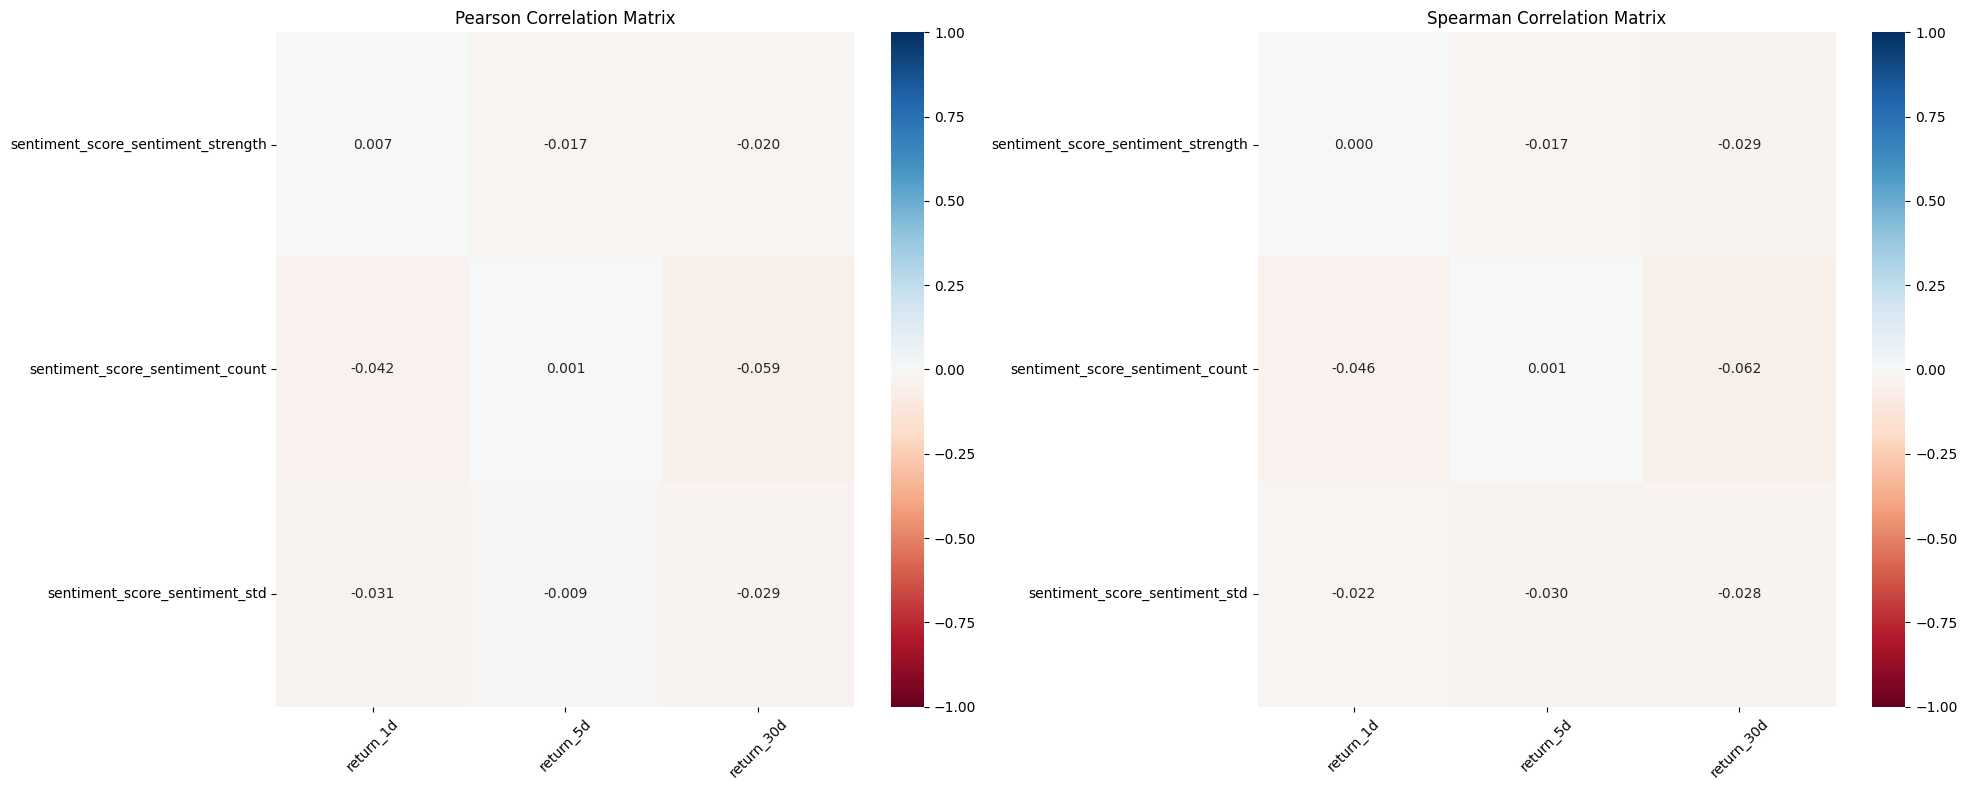


Generating scatter matrix...


<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

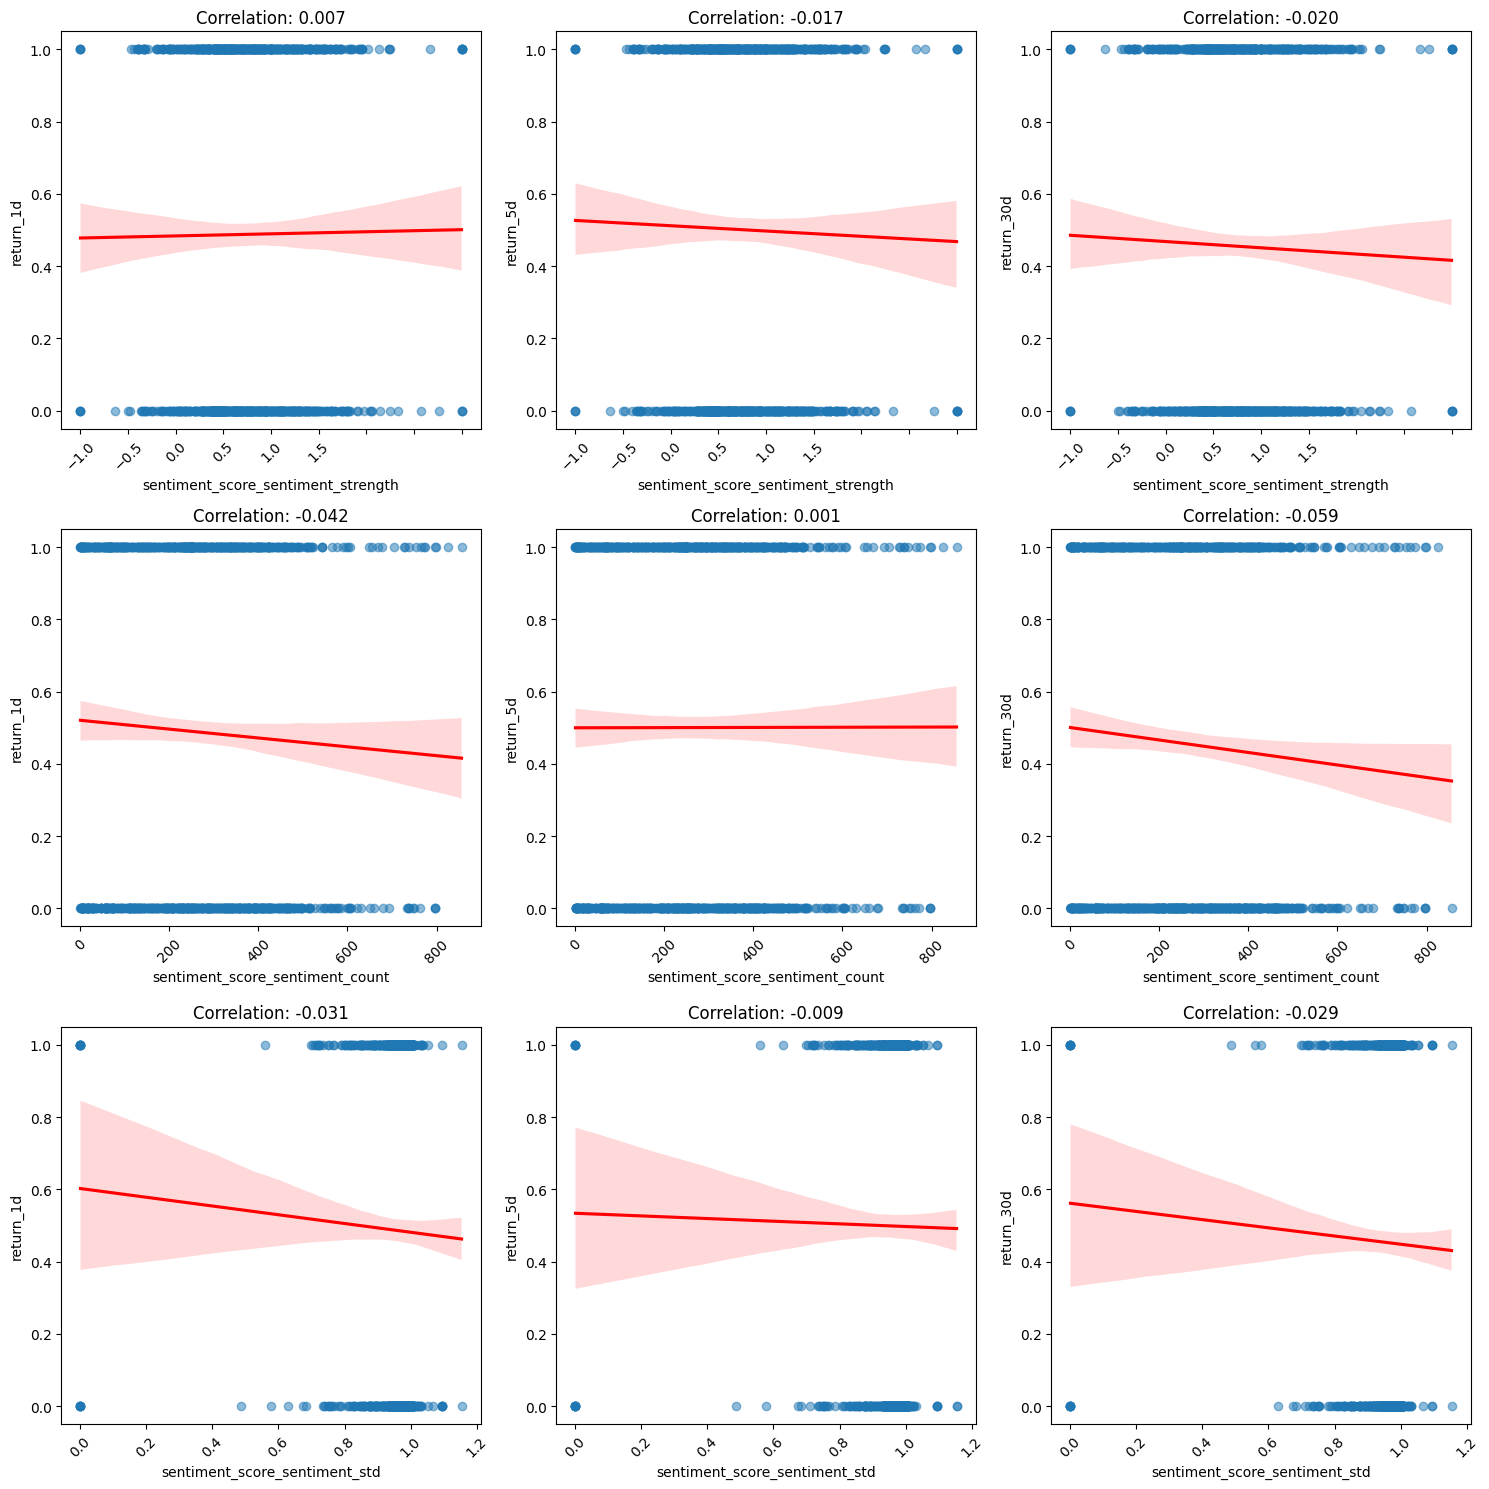

Generating correlation heatmaps...


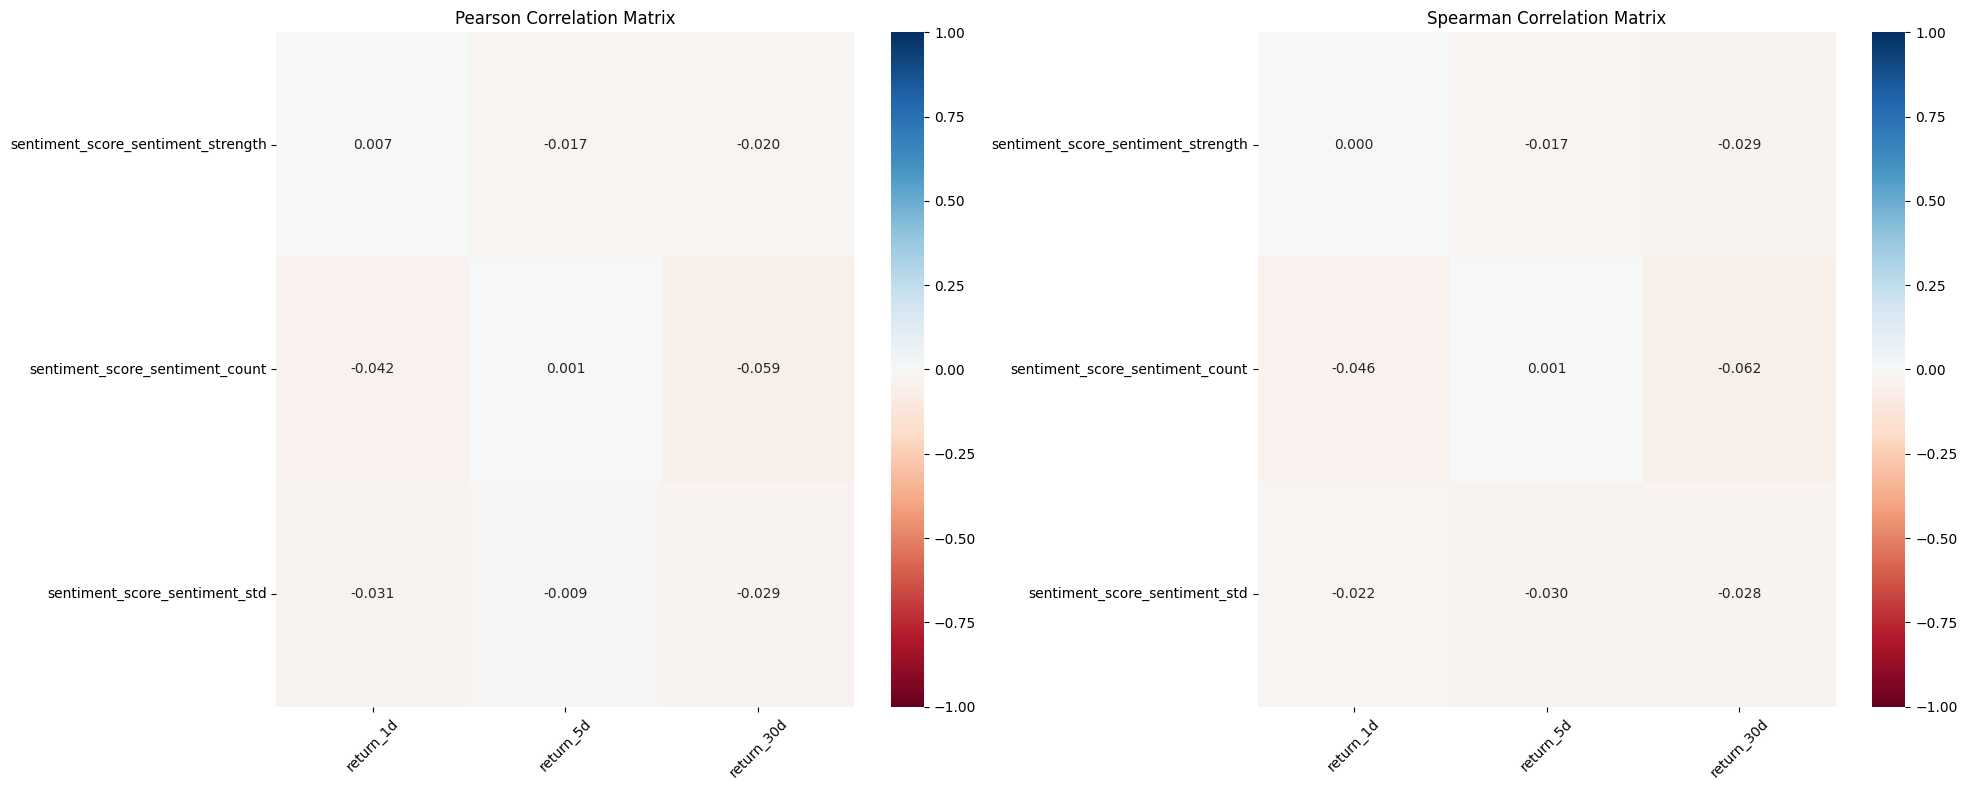


Generating scatter matrix...


<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-51-72b4a2964f12>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

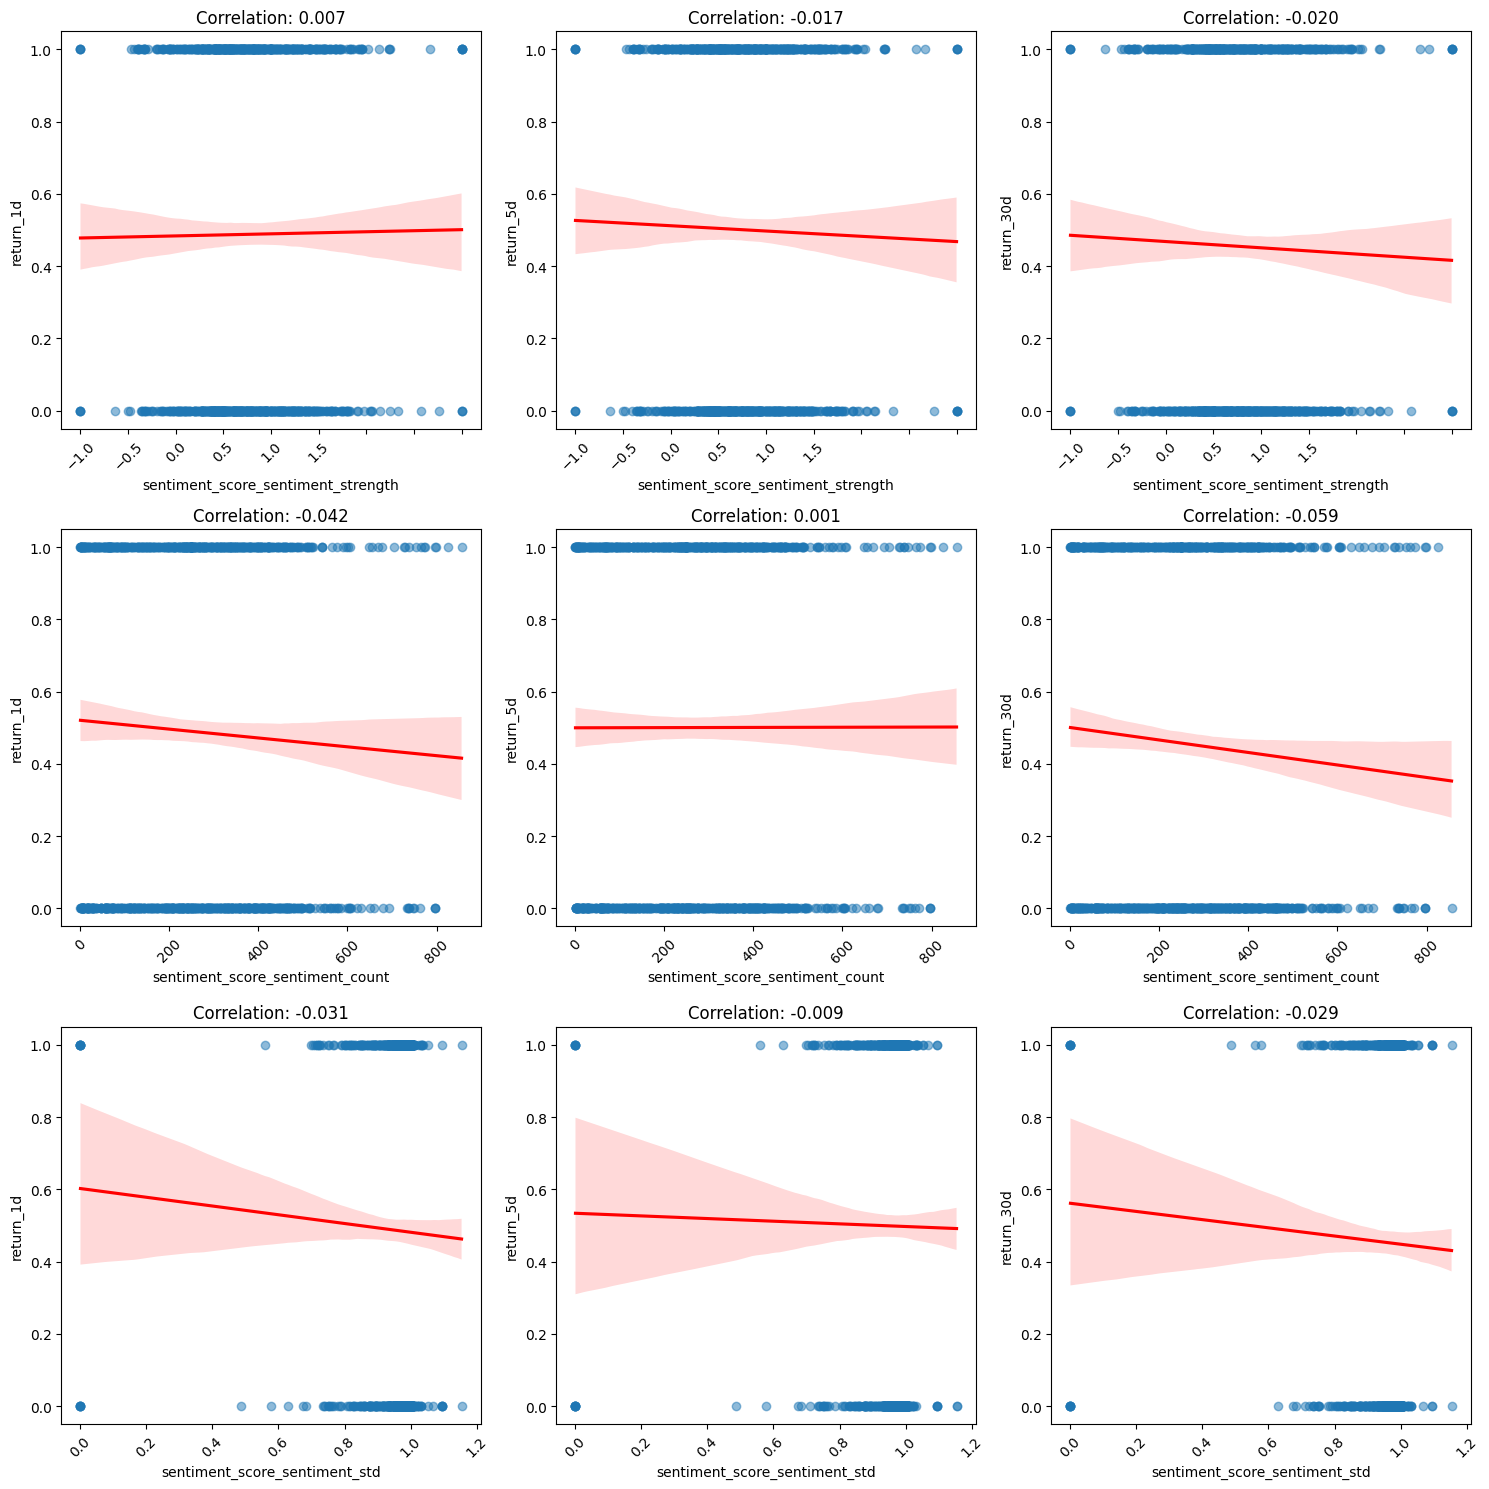


Generating sentiment distributions...


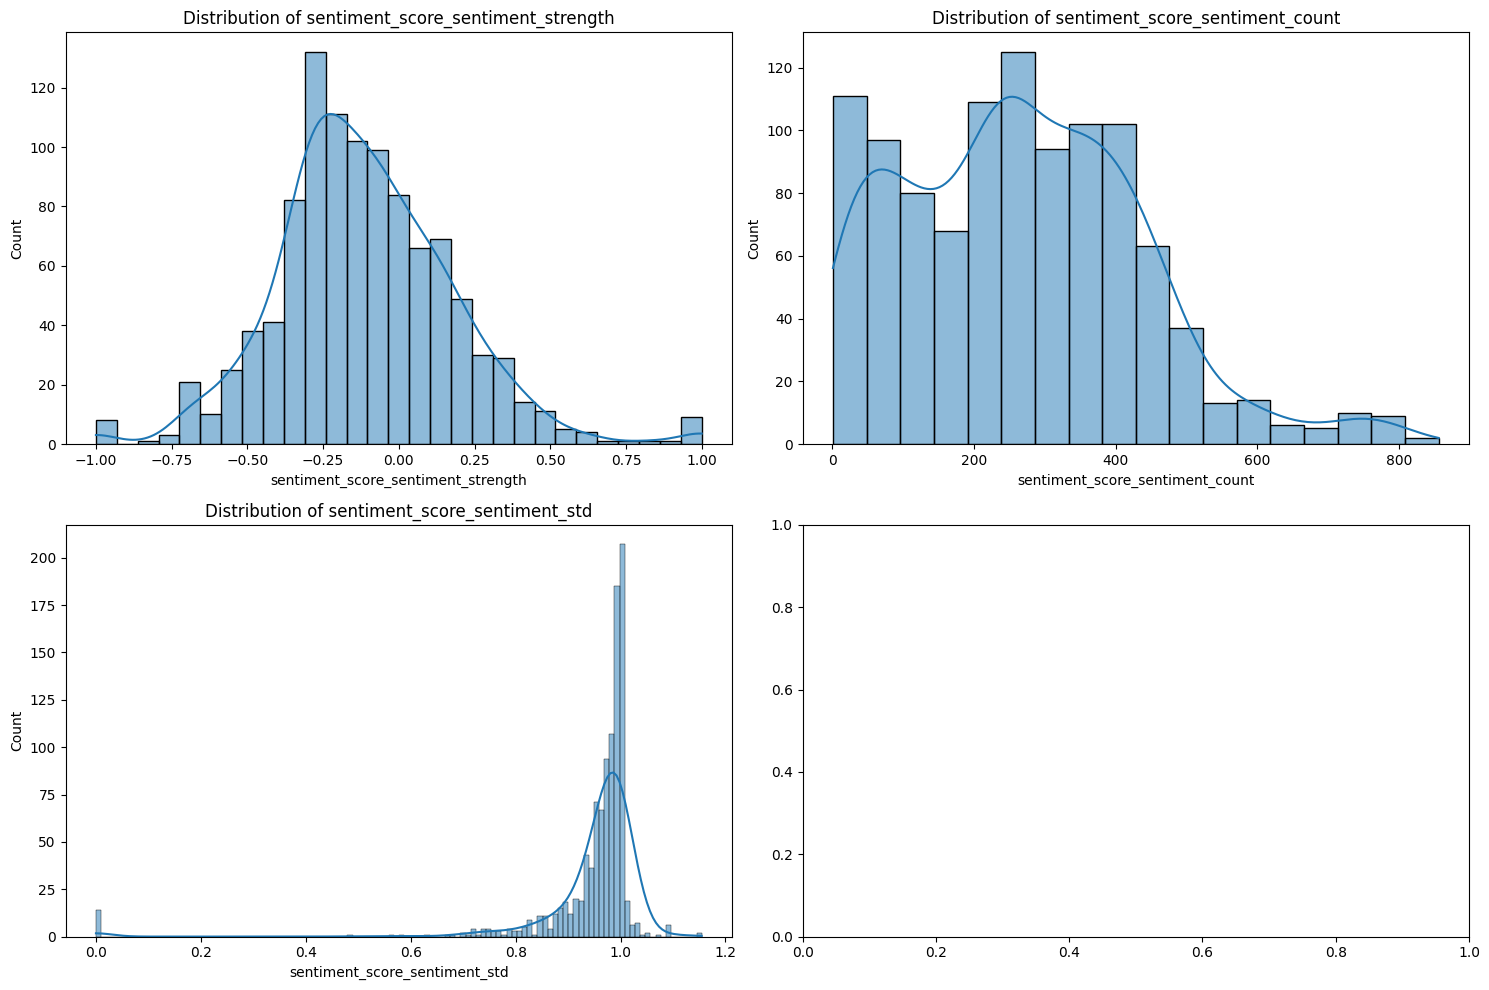


Generating return distributions...


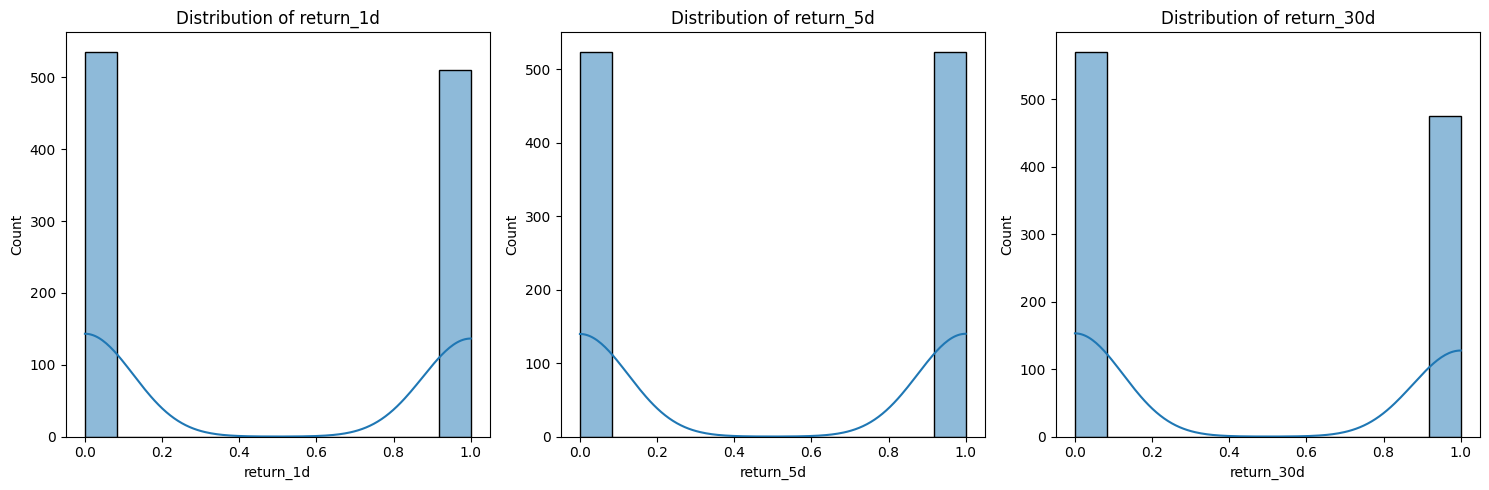


Generating significance results plot...


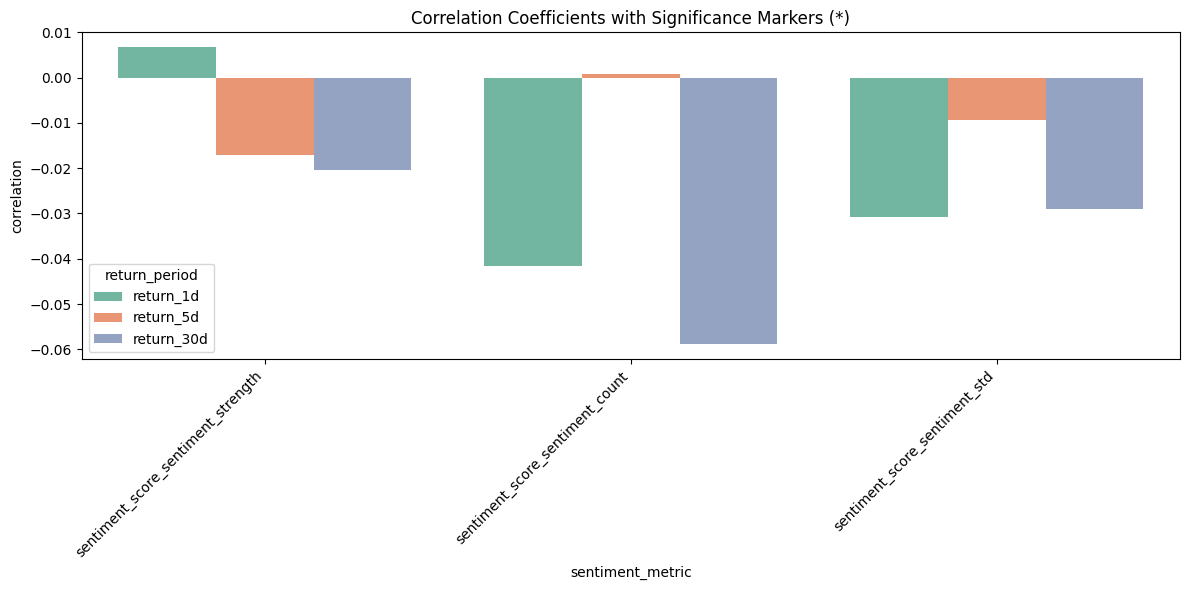

=== DOCUMENT-LEVEL SENTIMENT SUMMARY ===
Number of documents analyzed: 3

=== DATA QUALITY SUMMARY ===
Valid correlations for return_1d: 3
Valid correlations for return_5d: 3
Valid correlations for return_30d: 3

=== 1D RETURN CORRELATIONS ===
Sentiment Strength:
  Correlation: 0.0067 
  P-value: 0.8279
  Interpretation: No statistically significant correlation
Sentiment Count:
  Correlation: -0.0415 
  P-value: 0.1793
  Interpretation: No statistically significant correlation
Sentiment Std:
  Correlation: -0.0308 
  P-value: 0.3206
  Interpretation: No statistically significant correlation

=== 5D RETURN CORRELATIONS ===
Sentiment Strength:
  Correlation: -0.0171 
  P-value: 0.5805
  Interpretation: No statistically significant correlation
Sentiment Count:
  Correlation: 0.0009 
  P-value: 0.9776
  Interpretation: No statistically significant correlation
Sentiment Std:
  Correlation: -0.0093 
  P-value: 0.7635
  Interpretation: No statistically significant correlation

=== 30D RETURN 

In [ ]:
# Running here.
results = run_sentiment_correlation_analysis(df)

create_visualizations(
    combined_data=results['combined_data'],
    correlations=results['correlations'],
    significance_results=results['significance_results']
)

# Display text results
print(results['text_results'])

# Save results to files
results['combined_data'].to_csv('sentiment_returns_analysis.csv')
results['significance_results'].to_csv('correlation_significance_results.csv')

# Create a detailed summary DataFrame for further analysis if needed
summary_df = pd.DataFrame({
    'metric': results['significance_results']['sentiment_metric'],
    'return_period': results['significance_results']['return_period'],
    'correlation': results['significance_results']['correlation'].round(4),
    'p_value': results['significance_results']['p_value'].round(4),
    'significant': results['significance_results']['significant']
})

print("\nDetailed Summary Table:")
print(summary_df.to_string(index=False))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ok so we load in the big dataset, we need each year for every company. so aggregate across sentences by year. we also should have like a 'popular words' column per year.
# Which finds the most interesting (useful) words per year for a company. that we will use to drive our word cloud.

In [ ]:
#/content/drive/MyDrive/Colab Notebooks/data vis/10k_sentences_large100_sentiments.csv.gz
#sentenceID	sentence	docID	filingDate	section	name	tickers	reportDate	returns	sentiment	label_1d	label_5d	label_30d
# 0	0000001750_10-K_2020_section_1_0	ITEM 1.BUSINESS General AAR CORP. and its subsidiaries are referred to herein collectively as ‚ÄúAAR,‚Äù ‚ÄúCompany,‚Äù ‚Äúwe,‚Äù ‚Äúus,‚Äù and ‚Äúour‚Äù unless the context indicates otherwise.	0000001750_10-K_2020	7/21/20	0	AAR CORP	['AIR']	5/31/20	{'1d': {'closePriceEndDate': 19.010000228881836, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-22T00:00:00-04:00', 'startDate': '2020-07-20T00:00:00-04:00', 'ret': 0.04507969692349434}, '5d': {'closePriceEndDate': 17.719999313354492, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-27T00:00:00-04:00', 'startDate': '2020-07-20T00:00:00-04:00', 'ret': -0.025838438421487808}, '30d': {'closePriceEndDate': 19.25, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-08-20T00:00:00-04:00', 'startDate': '2020-07-20T00:00:00-04:00', 'ret': 0.05827374383807182}}	neutral	0	1	0

In [ ]:
!pip install sentence-transformers bertopic umap-learn plotly

In [ ]:
import pandas as pd
import numpy as np
import ast
import json
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download NLTK data files
nltk.download('stopwords')

# Load the dataset
data_path = '/content/drive/MyDrive/Colab Notebooks/data vis/10k_sentences_large100_sentiments.csv.gz'
df = pd.read_csv(data_path, compression='gzip', low_memory=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Convert 'filingDate' to datetime and extract year
df['filingDate'] = pd.to_datetime(df['filingDate'], errors='coerce')
df['year'] = df['filingDate'].dt.year.astype(str)

# Ensure 'tickers' column is a list
df['tickers'] = df['tickers'].apply(ast.literal_eval)


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
import plotly.express as px
import json
import ast
from datetime import datetime
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

class TenKPreprocessor:
    def __init__(self, input_file):
        self.input_file = input_file
        self.df = None
        self.sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

    def load_data(self):
        """Load and perform initial cleaning of the dataset."""
        print("Loading data...")
        self.df = pd.read_csv(self.input_file, compression='gzip')

        # Convert filing date to datetime
        self.df['filingDate'] = pd.to_datetime(self.df['filingDate'])
        self.df['year'] = self.df['filingDate'].dt.year

        # Clean tickers (convert string representation of list to actual list)
        self.df['tickers'] = self.df['tickers'].apply(ast.literal_eval)

        # Convert returns to dictionary
        self.df['returns'] = self.df['returns'].apply(ast.literal_eval)

    def process_yearly_metrics(self):
        """Process metrics needed for original visualizations."""
        print("Processing yearly metrics...")
        yearly_data = []

        # Get unique companies
        companies = set([ticker for tickers in self.df['tickers'] for ticker in tickers])
        print(f"Found {len(companies)} unique companies")

        for company in companies:
            print(f"\nProcessing company: {company}")
            # Filter for current company
            company_data = self.df[self.df['tickers'].apply(lambda x: company in x)]
            print(f"Found {len(company_data)} documents for {company}")

            # Group by year
            for year, group in company_data.groupby('year'):
                print(f"Processing year {year} ({len(group)} documents)")
                # Calculate sentiment counts and percentages
                sentiment_counts = group['sentiment'].value_counts()
                total = len(group)

                try:
                    # Calculate average stock price
                    avg_stock_price = np.mean([
                        returns['30d']['closePriceEndDate']
                        for returns in group['returns']
                        if '30d' in returns
                    ])

                    # Get key terms for word cloud
                    year_text = ' '.join(group['sentence'])
                    print(f"Extracting key terms from {len(year_text.split())} words")
                    key_terms = self._extract_key_terms(pd.Series([year_text]))

                    yearly_data.append({
                        'company': company,
                        'year': int(year),
                        'metrics': {
                            'sentiment_distribution': {
                                'positive': int(sentiment_counts.get('positive', 0)),
                                'negative': int(sentiment_counts.get('negative', 0)),
                                'neutral': int(sentiment_counts.get('neutral', 0))
                            },
                            'sentiment_percentages': {
                                'positivePercent': round((sentiment_counts.get('positive', 0) / total) * 100, 2),
                                'negativePercent': round((sentiment_counts.get('negative', 0) / total) * 100, 2),
                                'neutralPercent': round((sentiment_counts.get('neutral', 0) / total) * 100, 2)
                            },
                            'stockPrice': float(avg_stock_price),
                            'key_terms': key_terms
                        }
                    })
                    print(f"Successfully processed {company} for year {year}")
                except Exception as e:
                    print(f"Error processing {company} for year {year}: {str(e)}")
                    continue

        print(f"\nProcessed {len(yearly_data)} company-year combinations")
        return yearly_data

    def process_document_embeddings(self):
        """Process document embeddings and topic modeling."""
        print("Processing document embeddings and topics...")

        # Prepare documents
        docs, metadata = self._prepare_documents()

        # Create embeddings
        embeddings = self.sentence_model.encode(docs, show_progress_bar=True)

        # Reduce dimensionality for visualization
        umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine')
        reduced_embeddings = umap_model.fit_transform(embeddings)

        # Train topic model
        topic_model = BERTopic(
            embedding_model=None,
            min_topic_size=5,
            n_gram_range=(1, 2),
            calculate_probabilities=True
        )

        topics, probs = topic_model.fit_transform(docs, embeddings)

        # Prepare document visualization data
        doc_viz_data = []
        for i, (doc, meta) in enumerate(zip(docs, metadata)):
            doc_viz_data.append({
                'x': float(reduced_embeddings[i, 0]),
                'y': float(reduced_embeddings[i, 1]),
                'company': meta['company'][0],  # Take first ticker if multiple
                'year': meta['year'],
                'sentiment': meta['sentiment'],
                'topic': int(topics[i]),
                'topic_probs': probs[i].tolist() if probs is not None else None
            })

        # Get topic information
        topic_info = []
        for topic_id in range(len(topic_model.get_topics())):
            if topic_id != -1:  # Skip outlier topic
                topic_info.append({
                    'topic_id': topic_id,
                    'top_terms': topic_model.get_topic(topic_id),
                    'documents': [i for i, t in enumerate(topics) if t == topic_id]
                })

        return doc_viz_data, topic_info

    def _extract_key_terms(self, text_series, top_n=50):
        """Extract most significant terms using TF-IDF with adjusted parameters."""
        tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,  # Changed from 5 to 2
            max_df=0.95  # Added max_df parameter
        )

        try:
            tfidf_matrix = tfidf.fit_transform(text_series)
        except ValueError:
            # Fallback to even more lenient parameters if the first attempt fails
            tfidf = TfidfVectorizer(
                max_features=500,
                stop_words='english',
                ngram_range=(1, 1),  # Only single words
                min_df=1,  # Accept all terms
                max_df=1.0  # Accept all terms
            )
            tfidf_matrix = tfidf.fit_transform(text_series)

        feature_names = np.array(tfidf.get_feature_names_out())
        avg_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)

        # Get top terms
        top_indices = avg_tfidf.argsort()[-min(top_n, len(avg_tfidf)):][::-1]

        return dict(zip(
            feature_names[top_indices].tolist(),
            avg_tfidf[top_indices].tolist()
        ))

    def _prepare_documents(self):
        """Prepare documents for topic modeling."""
        docs = []
        metadata = []

        for doc_id, group in self.df.groupby('docID'):
            docs.append(' '.join(group['sentence']))
            metadata.append({
                'doc_id': doc_id,
                'company': group['tickers'].iloc[0],
                'year': group['filingDate'].iloc[0].year,
                'sentiment': group['sentiment'].mode()[0]
            })

        return docs, metadata

    def process_and_save(self, output_dir):
        """Process all data and save results."""
        self.load_data()

        # Process all data
        yearly_data = self.process_yearly_metrics()
        doc_viz_data, topic_info = self.process_document_embeddings()

        # Save results
        output = {
            'yearly_metrics': yearly_data,
            'document_visualization': doc_viz_data,
            'topic_information': topic_info,
            'companies': list(set([d['company'] for d in yearly_data]))
        }

        with open(f"{output_dir}/processed_10k_data.json", 'w') as f:
            json.dump(output, f, indent=2)

        print(f"Data saved to {output_dir}/processed_10k_data.json")
        return output

# Usage
if __name__ == "__main__":
    input_file = '/content/drive/MyDrive/Colab Notebooks/data vis/10k_sentences_large100_sentiments.csv.gz'
    output_dir = '/content/drive/MyDrive/Colab Notebooks/data vis'

    processor = TenKPreprocessor(input_file)
    processed_data = processor.process_and_save(output_dir)

In [ ]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import pandas as pd
import re  # Make sure to add this import at the top


def improve_key_terms(text, top_n=20):
    """Extract meaningful terms while filtering out common 10-K boilerplate terms."""

    # Custom stopwords for 10-K specific common terms
    additional_stopwords = {
        # Numbers and time-related
        r'\d+',  # Any number
        'fiscal', 'year', 'yearly', 'annual', 'quarterly', 'quarter', 'month', 'monthly',
        'ended', 'period', 'periods', 'date', 'dated', 'week', 'weekly',

        # Financial and reporting terms
        'financial', 'statements', 'consolidated', 'stock', 'million', 'billion',
        'revenue', 'income', 'loss', 'assets', 'liabilities', 'cash', 'shares',
        'stockholders', 'shareholders', 'dividend', 'dividends', 'earnings',
        'gaap', 'non-gaap', 'net', 'gross', 'operating', 'operations',
        'tax', 'taxes', 'profit', 'profits', 'sales', 'revenue', 'revenues',
        'cost', 'costs', 'expense', 'expenses', 'accounting', 'financial',
        'share', 'shares', 'common', 'preferred', 'class',

        # Document and legal terms
        'item', 'part', 'section', 'exhibit', 'filed', 'filing', 'form',
        'registrant', 'pursuant', 'following', 'company', 'corporation', 'incorporated',
        'report', 'reports', 'agreement', 'agreements', 'note', 'notes',
        'reference', 'references', 'schedule', 'schedules', 'significant',
        'respectively', 'approximately', 'statement', 'statements',

        # Business general terms
        'business', 'market', 'markets', 'products', 'services', 'customers',
        'operations', 'operating', 'management', 'company', 'companies',
        'subsidiary', 'subsidiaries', 'information', 'plan', 'plans',
        'matters', 'included', 'including', 'related', 'primarily',

        # Months and time
        'january', 'february', 'march', 'april', 'may', 'june',
        'july', 'august', 'september', 'october', 'november', 'december',

        # Generic terms
        'approximately', 'primarily', 'including', 'included', 'relates',
        'based', 'related', 'various', 'certain', 'regarding', 'general',
        'other', 'total', 'used', 'using', 'made', 'make', 'required',
        'requirement', 'requirements', 'current', 'currently',

        # Additional terms
        'see', 'also', 'well', 'within', 'without', 'under', 'page',
        'effective', 'description', 'table', 'above', 'below', 'use',
        'thereof', 'therefore', 'therein', 'thereby', 'thus',
        'whether', 'within', 'would', 'could', 'should', 'shall',
        'may', 'might', 'must', 'been', 'were', 'was', 'being',
        'more', 'most', 'some', 'such', 'than', 'then', 'they',
        'this', 'that', 'these', 'those', 'which', 'while', 'who',

        # Common verbs
        'with', 'from', 'have', 'has', 'had', 'having',
        'into', 'onto', 'upon', 'about', 'against', 'between',
        'through', 'during', 'before', 'after', 'above', 'below',
        'over', 'under', 'again', 'further', 'then', 'once',
        'here', 'there', 'when', 'where', 'why', 'how',
        'any', 'both', 'each', 'few', 'many', 'will', 'shall',
        'what', 'whom', 'whose', 'your', 'their', 'mine', 'ours'
    }

    def preprocess_text(text):
        """Additional text preprocessing."""
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove single characters
        text = re.sub(r'\b[a-zA-Z]\b', '', text)
        # Remove special characters and extra whitespace
        text = re.sub(r'[^\w\s]', ' ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text.lower()

    class CustomVectorizer(TfidfVectorizer):
        def build_preprocessor(self):
            preprocessor = super().build_preprocessor()

            def custom_preprocessor(doc):
                # First apply standard preprocessing
                text = preprocessor(doc)
                # Then apply our custom preprocessing
                text = preprocess_text(text)
                return text

            return custom_preprocessor

        def build_analyzer(self):
            analyzer = super().build_analyzer()

            def custom_analyzer(doc):
                tokens = analyzer(doc)
                # Additional token filtering
                filtered_tokens = [
                    token for token in tokens
                    if (len(token) >= 4 and  # Must be at least 4 chars
                        not any(char.isdigit() for char in token) and  # No numbers
                        not any(stopword in token.lower() for stopword in additional_stopwords))
                ]
                return filtered_tokens

            return custom_analyzer

    try:
        # Preprocess text
        processed_text = preprocess_text(text)

        # Initialize vectorizer
        tfidf = CustomVectorizer(
            max_features=1000,
            stop_words=list(additional_stopwords),
            ngram_range=(1, 3),  # Allow phrases up to 3 words
            min_df=2,
            max_df=0.7,
            token_pattern=r'[a-zA-Z]{3,}(?:\s+[a-zA-Z]{3,}){0,2}'
        )

        # Fit and transform
        tfidf_matrix = tfidf.fit_transform([processed_text])
        feature_names = np.array(tfidf.get_feature_names_out())
        avg_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)

        # Get top terms with additional filtering
        top_indices = avg_tfidf.argsort()[-50:][::-1]  # Get more terms initially for filtering

        filtered_terms = {}
        for idx in top_indices:
            term = feature_names[idx]
            score = avg_tfidf[idx]

            # Additional term validation
            if len(term.split()) > 1:  # For multi-word terms
                # Check if all words in the phrase are valid
                if all(len(word) >= 4 and word not in additional_stopwords
                      for word in term.split()):
                    filtered_terms[term] = float(score)
            else:  # For single words
                if (len(term) >= 4 and
                    term not in additional_stopwords and
                    not any(char.isdigit() for char in term)):
                    filtered_terms[term] = float(score)

            if len(filtered_terms) >= top_n:
                break

        # If we didn't get enough terms, try to get more
        if len(filtered_terms) < min(5, top_n):
            print(f"Warning: Only found {len(filtered_terms)} terms, falling back to simpler extraction")
            return _fallback_extraction(processed_text, additional_stopwords, top_n)

        return filtered_terms

    except Exception as e:
        print(f"Warning: Error in term extraction - {str(e)}, falling back to simpler extraction")
        return _fallback_extraction(processed_text, additional_stopwords, top_n)

def _fallback_extraction(processed_text, stopwords, top_n):
    """Fallback method for term extraction when TF-IDF fails."""
    words = processed_text.lower().split()
    # Get word frequencies
    word_freq = Counter(words)
    # Filter and sort words
    meaningful_words = {
        word: count
        for word, count in word_freq.most_common(100)
        if (word not in stopwords and
            len(word) >= 4 and
            not any(char.isdigit() for char in word))
    }
    # Convert counts to scores between 0 and 1
    max_count = max(meaningful_words.values()) if meaningful_words else 1
    return {
        word: count/max_count
        for word, count in list(meaningful_words.items())[:top_n]
    }

def post_process_json(input_path, output_path, sentences_file):
    """Load JSON and original sentences file, improve key terms, and save updated JSON."""
    print("Loading JSON file...")
    with open(input_path, 'r') as f:
        data = json.load(f)

    print("Loading original sentences file...")
    df = pd.read_csv(sentences_file, compression='gzip')
    df['filingDate'] = pd.to_datetime(df['filingDate'])
    df['year'] = df['filingDate'].dt.year
    df['tickers'] = df['tickers'].apply(ast.literal_eval)

    print("Post-processing key terms...")
    company_year_texts = {}

    # Create text for each company-year combination from original sentences
    for company in set([ticker for tickers in df['tickers'] for ticker in tickers]):
        company_data = df[df['tickers'].apply(lambda x: company in x)]

        for year, group in company_data.groupby('year'):
            key = (company, year)
            # Combine all sentences for this company-year
            company_year_texts[key] = ' '.join(group['sentence'].tolist())

    # Update key terms using the original text
    print("Processing key terms for each company-year combination...")
    total = len(data['yearly_metrics'])
    for i, entry in enumerate(data['yearly_metrics']):
        company = entry['company']
        year = entry['year']
        key = (company, year)

        if key in company_year_texts:
            print(f"Processing {company} - {year} ({i+1}/{total})")
            try:
                # Extract new key terms using the original text
                new_terms = improve_key_terms(company_year_texts[key])
                # Update the entry
                entry['metrics']['key_terms'] = new_terms
            except Exception as e:
                print(f"Error processing {company} - {year}: {str(e)}")
                continue

    print("Saving updated JSON...")
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)

    print("Post-processing complete!")
    return data


# Usage
if __name__ == "__main__":
    input_path = '/content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data.json'
    output_path = '/content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data_improved.json'
    sentences_file = '/content/drive/MyDrive/Colab Notebooks/data vis/10k_sentences_large100_sentiments.csv.gz'

    import re
    import ast

    updated_data = post_process_json(input_path, output_path, sentences_file)

    # Print sample of improved key terms
    print("\nSample of improved key terms:")
    sample_entry = updated_data['yearly_metrics'][0]
    print(f"\nCompany: {sample_entry['company']}, Year: {sample_entry['year']}")
    print("Key Terms:")
    for term, score in sample_entry['metrics']['key_terms'].items():
        print(f"  {term}: {score:.4f}")

In [ ]:
def clean_existing_json(input_path, output_path):
    """Clean existing key terms without reprocessing text."""

    # Words to remove
    words_to_remove = {
        'with', 'from', 'have', 'has', 'had', 'having',
        'into', 'onto', 'upon', 'about', 'against', 'between',
        'through', 'during', 'before', 'after', 'above', 'below',
        'over', 'under', 'again', 'further', 'then', 'once',
    }

    print("Loading JSON file...")
    with open(input_path, 'r') as f:
        data = json.load(f)

    print("Cleaning key terms...")
    for entry in data['yearly_metrics']:
        # Get current key terms
        current_terms = entry['metrics']['key_terms']

        # Clean terms
        cleaned_terms = {}
        for term, score in current_terms.items():
            # Skip if the term contains any numbers
            if any(char.isdigit() for char in term):
                continue

            # Skip if the term is in our remove list
            if any(word in term.lower().split() for word in words_to_remove):
                continue

            # Keep the term if it passes our filters
            cleaned_terms[term] = score

        # Update the entry with cleaned terms
        entry['metrics']['key_terms'] = cleaned_terms

    print("Saving cleaned JSON...")
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)

    print("Cleaning complete!")
    return data

# Usage
input_path = '/content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data_improved.json'
output_path = '/content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data_final.json'

cleaned_data = clean_existing_json(input_path, output_path)

# Print sample of cleaned terms
print("\nSample of cleaned key terms:")
sample_entry = cleaned_data['yearly_metrics'][0]
print(f"\nCompany: {sample_entry['company']}, Year: {sample_entry['year']}")
print("Key Terms:")
for term, score in sample_entry['metrics']['key_terms'].items():
    print(f"  {term}: {score:.4f}")

Loading JSON file...
Cleaning key terms...
Saving cleaned JSON...
Cleaning complete!

Sample of cleaned key terms:

Company: MEI, Year: 1995
Key Terms:
  electronics: 0.7778
  methode: 0.7407
  years: 0.7407
  herein: 0.6296
  automotive: 0.4444
  three: 0.4074
  material: 0.3333
  will: 0.3333
  rate: 0.3333
  directors: 0.3333
  controls: 0.2963
  capital: 0.2963
  environmental: 0.2963
  previously: 0.2963


In [ ]:
import pandas as pd
import json
import ast

def create_ticker_to_company_map(df):
    """
    Create a mapping of ticker symbols to company names from the DataFrame.
    Handles cases where tickers column contains lists.

    Args:
        df (pd.DataFrame): DataFrame containing 'tickers' and 'name' columns

    Returns:
        dict: Mapping of ticker symbols to company names
    """
    ticker_to_company = {}

    # Convert tickers from string to list if needed
    if isinstance(df['tickers'].iloc[0], str):
        df['tickers'] = df['tickers'].apply(ast.literal_eval)

    # Create mapping
    for _, row in df.iterrows():
        # Get the first ticker from the list (assuming it's the primary ticker)
        if row['tickers'] and len(row['tickers']) > 0:
            ticker = row['tickers'][0]  # Take the first ticker
            if ticker not in ticker_to_company:  # Only add if we haven't seen this ticker before
                ticker_to_company[ticker] = row['name']

    return ticker_to_company

def update_json_company_names(input_json_path, output_json_path, ticker_to_company):
    """
    Update the JSON file by replacing ticker symbols with company names.

    Args:
        input_json_path (str): Path to input JSON file
        output_json_path (str): Path to save updated JSON file
        ticker_to_company (dict): Mapping of ticker symbols to company names
    """
    # Load the JSON data
    with open(input_json_path, 'r') as f:
        data = json.load(f)

    # Keep track of unmapped tickers
    unmapped_tickers = set()

    # Update company names in yearly_metrics
    for entry in data['yearly_metrics']:
        ticker = entry['company']
        if ticker in ticker_to_company:
            entry['company'] = ticker_to_company[ticker]
        else:
            unmapped_tickers.add(ticker)

    # Print warning for unmapped tickers
    if unmapped_tickers:
        print("\nWarning: Could not find company names for these tickers:", sorted(list(unmapped_tickers)))

    # Save updated JSON
    with open(output_json_path, 'w') as f:
        json.dump(data, f, indent=2)

    return data

def main():
    # File paths
    data_path = '/content/drive/MyDrive/Colab Notebooks/data vis/10k_sentences_large100_sentiments.csv.gz'
    input_json_path = '/content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data_improved.json'
    output_json_path = '/content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data_with_names.json'

    # Load the original dataset
    print("Loading original dataset...")
    df = pd.read_csv(data_path, compression='gzip', low_memory=False)

    # Create ticker to company name mapping
    print("Creating ticker to company name mapping...")
    ticker_to_company = create_ticker_to_company_map(df)

    # Print sample of mappings
    print("\nSample of ticker to company mappings:")
    sample_items = list(ticker_to_company.items())[:5]
    for ticker, name in sample_items:
        print(f"{ticker}: {name}")

    # Update JSON with company names
    print("\nUpdating JSON with company names...")
    updated_data = update_json_company_names(input_json_path, output_json_path, ticker_to_company)

    # Print sample of updated data
    print("\nSample of updated data:")
    sample_entry = updated_data['yearly_metrics'][0]
    print(f"Company: {sample_entry['company']}")
    print(f"Year: {sample_entry['year']}")

    print("\nProcess completed! Updated JSON saved to:", output_json_path)

if __name__ == "__main__":
    main()

Loading original dataset...
Creating ticker to company name mapping...

Sample of ticker to company mappings:
AIR: AAR CORP
ALX: ALEXANDERS INC
AXR: AMREP CORP.
ARW: ARROW ELECTRONICS INC
BMI: BADGER METER INC

Updating JSON with company names...

Sample of updated data:
Company: METHODE ELECTRONICS INC
Year: 1995

Process completed! Updated JSON saved to: /content/drive/MyDrive/Colab Notebooks/data vis/processed_10k_data_with_names.json
